# Natural language processing to Trump tweet

This analysis performs natural language processing to tweets made by President Trump.

## Setup

In [2]:
import tweepy as tw

import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.corpora.dictionary import Dictionary
from textblob import TextBlob
from wordcloud import WordCloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

C:\Users\yukic\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yukic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yukic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yukic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yukic\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Authentication

Get your onw authentication information from Twitter Developer and fill in.

In [3]:
access_token = "AAAAAAAAAA"
access_token_secret = "BBBBBBBBBB"
consumer_key = "CCCCCCCCCC"
consumer_secret = "DDDDDDDDDD"

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth, wait_on_rate_limit = True)

## Getting data

When you download tweets, you get only recent tweets, so comment out the below to make data fixed.

In [4]:
NAME = "realDonaldTrump"
COUNT = 1000

tweets = api.user_timeline(screen_name = NAME, count = COUNT, include_rts = False)

# Get necesarry data
tweet = [[t.user.screen_name, t.user.name, t.created_at, t.text, t.favorite_count] for t in tweets]

# make it pandas datafram
tweet_df = pd.DataFrame(tweet, columns = ["screen_name", "user_name", "created_at", "text", "favorite_count"])

Created_at returns datetime (year, month, day, hour, minute, second), but timezone is not adjusted. Created_at is UTC time when the Tweet was created. UTC is Coordinated Universal Time, so created_at returns time at Greenwitch Mean Time at UK.

## Save tweet data

In [26]:
# tweet_df.to_csv('C:\\Users\\yukic\\Documents\\Twitter\\trump_tweet_data_20190806.csv', index = None)

## Load tweet data from csv

Since the tweets that we can get using Twitter API change every time, we fix for now and load from the stored CSV file.

In [8]:
tweet_df = pd.read_csv("trump_tweet_data_20190806.csv")
tweet_df.head()

,screen_name,user_name,created_at,text,favorite_count
0,realDonaldTrump,Donald J. Trump,2019-08-06 16:28:23,Thank you @JimCramer @CNBC! https://t.co/DW7HD...,10923
1,realDonaldTrump,Donald J. Trump,2019-08-06 16:24:54,"Thank you Mr. Wonderful, I like you too! @kevi...",12985
2,realDonaldTrump,Donald J. Trump,2019-08-06 12:36:44,"As they have learned in the last two years, ou...",55276
3,realDonaldTrump,Donald J. Trump,2019-08-06 12:00:41,Massive amounts of money from China and other ...,49902
4,realDonaldTrump,Donald J. Trump,2019-08-06 11:47:06,....in 2020.” Lou Dobbs stated that this is a ...,57432


## Explore data

In [9]:
m = 3
index = np.random.randint(0, tweet_df.shape[1], m)

for i in range(m):
    print(tweet_df['text'][i])

Thank you @JimCramer @CNBC! https://t.co/DW7HDA0WEK
Thank you Mr. Wonderful, I like you too! @kevinolearytv @CNBC https://t.co/8n5qcTVSp2
As they have learned in the last two years, our great American Farmers know that China will not be able to hurt the… https://t.co/qlBy5ZKcJj


In [10]:
# making proper time series setting
tweet_df['created_at'] = pd.to_datetime(tweet_df['created_at'])
tweet_df = tweet_df.set_index('created_at')

In [11]:
count_daily = tweet_df['screen_name'].resample('D').count()

mean_trump = np.mean(count_daily)
std_trump = np.std(count_daily)
print("Average number of Trump daily tweets: {:.1f}".format(mean_trump))
print("Standard deviation of the tweets: {:.1f}".format(std_trump))

Average number of Trump daily tweets: 13.3
Standard deviation of the tweets: 5.4


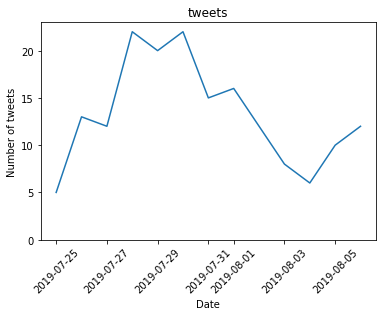

In [12]:
plt.plot(count_daily.index, count_daily)
plt.title("tweets")
plt.xlabel("Date")
plt.ylabel("Number of tweets")
plt.ylim((0, max(count_daily)+1))
plt.xticks(rotation = 45)
plt.show()

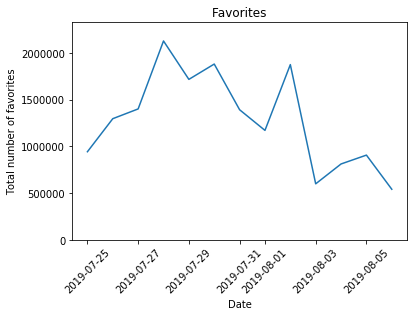

In [13]:
favorite_daily = tweet_df['favorite_count'].resample('D').sum()

plt.plot(favorite_daily.index, favorite_daily)
plt.title("Favorites")
plt.xlabel("Date")
plt.ylabel("Total number of favorites")
plt.ylim((0, max(favorite_daily)+200000))
plt.xticks(rotation = 45)
plt.show()

## Tokenization

Tokenization is cutting sentences into pieces process. There are several ways to do it, so we try them to single tweet and check how the results look like. Some terminology with respect to tokenization is the following. <br>
<font color = red> **Stop words** </font>: commonly used words, such as "the", "a", that usually search engine is programmed to ignore. <br>
<font color = red> **Lemmatization** </font>: removing inflectional endings and return the base or dictionary form of words.

In [14]:
text = tweet_df['text'][1]
text

'Thank you Mr. Wonderful, I like you too! @kevinolearytv @CNBC https://t.co/8n5qcTVSp2'

In [15]:
# word_tokenize
wt = word_tokenize(text)
np.transpose(wt)

array(['Thank', 'you', 'Mr', '.', 'Wonderful', ',', 'I', 'like', 'you',
       'too', '!', '@', 'kevinolearytv', '@', 'CNBC', 'https', ':',
       '//t.co/8n5qcTVSp2'], dtype='<U17')

In [16]:
# TweetTokenizer
tknzr = TweetTokenizer()
tt = tknzr.tokenize(text)
np.transpose(tt)

array(['Thank', 'you', 'Mr', '.', 'Wonderful', ',', 'I', 'like', 'you',
       'too', '!', '@kevinolearytv', '@CNBC', 'https://t.co/8n5qcTVSp2'],
      dtype='<U23')

In [17]:
# word_tokenize with lowercase and only alphabetical words
wt_lower_isalpha = [w for w in word_tokenize(text.lower()) if w.isalpha()]
np.transpose(wt_lower_isalpha)

array(['thank', 'you', 'wonderful', 'i', 'like', 'you', 'too',
       'kevinolearytv', 'cnbc', 'https'], dtype='<U13')

In [18]:
# word_tokenize with removing English stopwords
wt = word_tokenize(text)
no_stops = [t for t in wt if t not in stopwords.words('english')]
np.transpose(no_stops)

array(['Thank', 'Mr', '.', 'Wonderful', ',', 'I', 'like', '!', '@',
       'kevinolearytv', '@', 'CNBC', 'https', ':', '//t.co/8n5qcTVSp2'],
      dtype='<U17')

In [19]:
# using lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
wt = word_tokenize(text)
np.transpose([wordnet_lemmatizer.lemmatize(t) for t in wt])

array(['Thank', 'you', 'Mr', '.', 'Wonderful', ',', 'I', 'like', 'you',
       'too', '!', '@', 'kevinolearytv', '@', 'CNBC', 'http', ':',
       '//t.co/8n5qcTVSp2'], dtype='<U17')

In [20]:
# One way of combination
tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
no_stops = [t for t in tokens if t not in stopwords.words('english')]
no_stops

['thank', 'wonderful', 'like', 'kevinolearytv', 'cnbc', 'https']

In [21]:
# Another way of combination
alpha_only = [w for w in word_tokenize(text.lower()) if w.isalpha()]
no_stops = [t for t in alpha_only if t not in stopwords.words('english')]
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
lemmatized

['thank', 'wonderful', 'like', 'kevinolearytv', 'cnbc', 'http']

In [22]:
# ruling out specific words, here https and http
tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
no_stops = [t for t in tokens if t not in stopwords.words('english')]
customized = [c for c in no_stops if c not in ["https", "http"]]
customized

['thank', 'wonderful', 'like', 'kevinolearytv', 'cnbc']

The last way of tokenization seems to be nice.

## Bag-of-words from several tweets

We apply tokenization to all the tweets, and we cound the number of each word appearing, which is called bag-of-words, i.e. word frequency.

In [23]:
n = tweet_df.shape[0]
joined_tweets = []

for i in range(n):
    # get each tweet
    text = tweet_df['text'][i]
    # tokenize only alphabetical words with lowercase
    tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
    # remove stop words to get only more meaningful words for analysis
    no_stops = [t for t in tokens if t not in stopwords.words('english')]
    # customized filtering
    customized = [c for c in no_stops if c not in ["https", "http"]]
    
    joined_tweets = joined_tweets + customized

In [24]:
counter = Counter(joined_tweets)
counter.most_common(3)

[('great', 28), ('thank', 15), ('china', 15)]

I kinda feel happy to see "great" is the most frequent, becuase I have impression that President Trump always says great.

## Visualize word frequency

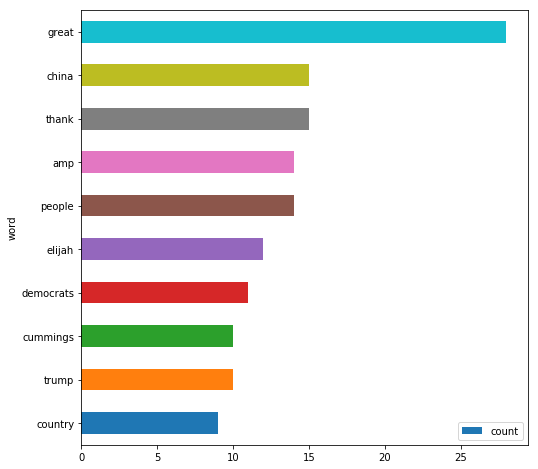

In [25]:
word_df = pd.DataFrame(counter.most_common(10), columns = ['word', 'count'])

fig, ax = plt.subplots(figsize = (8, 8))
word_df.sort_values(by = 'count').plot.barh(x = 'word', y = 'count', ax = ax)
plt.show()

## Word cloud

Word cloud is one way of visualiaing word frequency. The more frequently words appear, the bigger the words show up in an image.

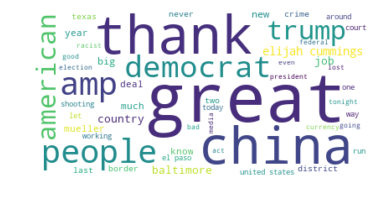

In [26]:
sep = ' '
joined_tweets_str = sep.join(joined_tweets)

SEED = 8

cloud = WordCloud(max_font_size = 80, max_words = 50, 
                  background_color = 'white', random_state = SEED).generate(joined_tweets_str)

plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [27]:
# save the image
cloud.to_file("cloud.png")

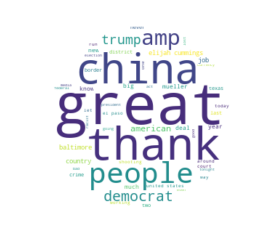

In [28]:
# making circle word cloud
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(max_font_size = 80, max_words = 50, 
               background_color = 'white', random_state = SEED,
               mask = mask).generate(joined_tweets_str)

plt.axis('off')
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

## Sentiment analysis by textblob

TextBlob method sentiment returns polarity score and subjectivity score. <br>
<font color = red> **Polarity** </font>: value from -1 to 1, -1 means negative statements and 1 means positive. <br>
<font color = red> **Subjectivity** </font>: from 0 to 1, if the statement is more personal opinion, emotional, judgemental, the score is higher.

In [29]:
text_list = tweet_df['text'].to_string(header = False, index = False).split('\n')

# empty list to store sentiment data
polarity_list = []
subjectivity_list = []

for i in range(len(text_list)):
    
    # get sentiment
    valance = TextBlob(text_list[i])
    
    # extract polarity and subjectivity scores
    pol = valance.sentiment.polarity
    sub = valance.sentiment.subjectivity
    
    # save results
    polarity_list.append(pol)
    subjectivity_list.append(sub)
    
tweet_df['polarity'] = polarity_list
tweet_df['subjectivity'] = subjectivity_list
tweet_df.head()

,screen_name,user_name,text,favorite_count,polarity,subjectivity
created_at,,,,,,
2019-08-06 16:28:23,realDonaldTrump,Donald J. Trump,Thank you @JimCramer @CNBC! https://t.co/DW7HD...,10923,0.0000,0.000000
2019-08-06 16:24:54,realDonaldTrump,Donald J. Trump,"Thank you Mr. Wonderful, I like you too! @kevi...",12985,1.0000,1.000000
2019-08-06 12:36:44,realDonaldTrump,Donald J. Trump,"As they have learned in the last two years, ou...",55276,0.0000,0.066667
2019-08-06 12:00:41,realDonaldTrump,Donald J. Trump,Massive amounts of money from China and other ...,49902,-0.0625,0.687500
2019-08-06 11:47:06,realDonaldTrump,Donald J. Trump,....in 2020.” Lou Dobbs stated that this is a ...,57432,0.0000,0.000000


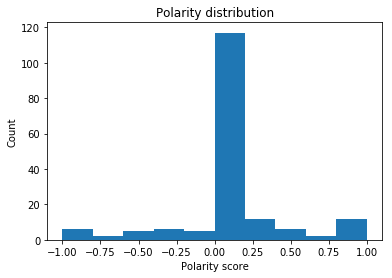

In [42]:
plt.hist(tweet_df['polarity'])
plt.title('Polarity distribution')
plt.xlabel('Polarity score')
plt.ylabel('Count')
plt.show()

In [31]:
tweet_df.loc[tweet_df['polarity'] > 0.9, "text"].values

array(['Thank you Mr. Wonderful, I like you too! @kevinolearytv @CNBC https://t.co/8n5qcTVSp2',
       'A great couple! https://t.co/h0o1laZ7e3',
       '....I am very happy for Eddie Gallagher and his family!'],
      dtype=object)

In [32]:
tweet_df.loc[tweet_df['polarity'] < -0.9, "text"].values

array(['Terrible shootings in ElPaso, Texas. Reports are very bad, many killed. Working with State and Local authorities, a… https://t.co/p9I5Pnj6ej',
       'China is doing very badly, worst year in 27 - was supposed to start buying our agricultural product now - no signs… https://t.co/P5IZSWbosI',
       'Baltimore’s numbers are the worst in the United States on Crime and the Economy. Billions of dollars have been pump… https://t.co/8mYWBiEs51',
       'Very disappointed in Prime Minister Stefan Löfven for being unable to act. Sweden has let our African American Comm… https://t.co/f0hfApJ8tz'],
      dtype=object)

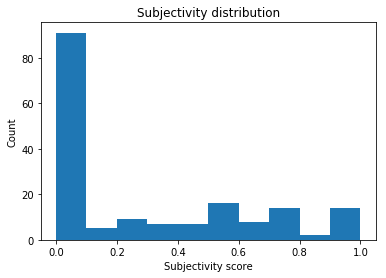

In [43]:
plt.hist(tweet_df['subjectivity'])
plt.title('Subjectivity distribution')
plt.xlabel('Subjectivity score')
plt.ylabel('Count')
plt.show()

In [34]:
tweet_df.loc[tweet_df['subjectivity'] > 0.9, "text"].values

array(['Thank you Mr. Wonderful, I like you too! @kevinolearytv @CNBC https://t.co/8n5qcTVSp2',
       '....this legislation with desperately needed immigration reform. We must have something good, if not GREAT, come ou… https://t.co/RgrBOhEU9F',
       '....Melania and I send our heartfelt thoughts and prayers to the great people of Texas.',
       'Terrible shootings in ElPaso, Texas. Reports are very bad, many killed. Working with State and Local authorities, a… https://t.co/p9I5Pnj6ej',
       'Beautiful evening in Cincinnati, Ohio tonight — with GREAT American Patriots! #KAG2020 https://t.co/wDN5B4Gp87',
       '....I am very happy for Eddie Gallagher and his family!',
       'Wow! Morning Joe &amp; Psycho ratings have really crashed. Very small audience. People are tired of hearing Fake News d… https://t.co/UtIc2v8yIw',
       'China is doing very badly, worst year in 27 - was supposed to start buying our agricultural product now - no signs… https://t.co/P5IZSWbosI',
       'Balt

My impression is if tweets with higher absolute value of polarity tend to show up higher subjectivity.

## Sentiment analysis by vader

SentimentIntensityAnalyzer of vader module returns neg (negative), neu (neutral), pos (positive), and compound. <br>
the first three represent the proportion that a certain statement fall in. <br>
<font color = red> **Compound** </font>: from -1 to 1, -1 negative, 1 positive. <br>

In [35]:
#instantiate
sid = SentimentIntensityAnalyzer()

# calculate sentiment score
sentiment_score = tweet_df['text'].apply(sid.polarity_scores)

# merge with original dataframe
sentiment_score_df = pd.DataFrame.from_records(sentiment_score)
sentiment_score_df = sentiment_score_df.set_index(tweet_df.index)

tweet_df = pd.concat([tweet_df, sentiment_score_df], axis = 1)

In [36]:
tweet_df.head()

,screen_name,user_name,text,favorite_count,polarity,subjectivity,compound,neg,neu,pos
created_at,,,,,,,,,,
2019-08-06 16:28:23,realDonaldTrump,Donald J. Trump,Thank you @JimCramer @CNBC! https://t.co/DW7HD...,10923,0.0000,0.000000,0.4199,0.000,0.589,0.411
2019-08-06 16:24:54,realDonaldTrump,Donald J. Trump,"Thank you Mr. Wonderful, I like you too! @kevi...",12985,1.0000,1.000000,0.8398,0.000,0.438,0.562
2019-08-06 12:36:44,realDonaldTrump,Donald J. Trump,"As they have learned in the last two years, ou...",55276,0.0000,0.066667,0.1779,0.115,0.746,0.139
2019-08-06 12:00:41,realDonaldTrump,Donald J. Trump,Massive amounts of money from China and other ...,49902,-0.0625,0.687500,0.4215,0.000,0.887,0.113
2019-08-06 11:47:06,realDonaldTrump,Donald J. Trump,....in 2020.” Lou Dobbs stated that this is a ...,57432,0.0000,0.000000,-0.4215,0.167,0.746,0.088


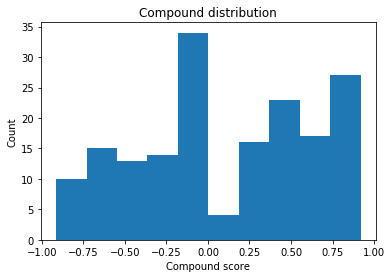

In [44]:
plt.hist(tweet_df['compound'])
plt.title('Compound distribution')
plt.xlabel('Compound score')
plt.ylabel('Count')
plt.show()

In [38]:
tweet_df.loc[tweet_df["compound"] > 0.9, "text"].values

array(['Great working with you John. A big win for our amazing ranchers! https://t.co/m2PjlbTHA9',
       '....Chariman Kim has a great and beautiful vision for his country, and only the United States, with me as President… https://t.co/Nn56xpzKr2',
       'It is the 25th Anniversary of a GREAT Organization run by people who truly love our Country, @JudicialWatch. On beh… https://t.co/HFCWOPNGH5'],
      dtype=object)

In [39]:
tweet_df.loc[tweet_df["compound"] < -0.9, "text"].values

array(['....used currency manipulation to steal our businesses and factories, hurt our jobs, depress our workers’ wages and… https://t.co/UUdKKRsePC',
       'Terrible shootings in ElPaso, Texas. Reports are very bad, many killed. Working with State and Local authorities, a… https://t.co/p9I5Pnj6ej'],
      dtype=object)

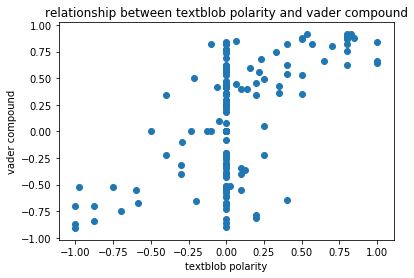

In [40]:
plt.scatter(tweet_df['polarity'], tweet_df['compound'])
plt.title('relationship between textblob polarity and vader compound')
plt.xlabel('textblob polarity')
plt.ylabel('vader compound')
plt.show()

Textblob often can't calculate polarity and returns 0, but Vader compound seems to be able to calculate some kind of score in many cases. But generally, polarity and compound keeps positive correlation and similar results.

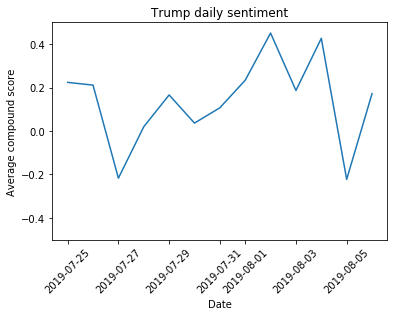

In [50]:
compound_daily = tweet_df['compound'].resample('D').mean()

plt.plot(compound_daily.index, compound_daily.values)
plt.title("Trump daily sentiment")
plt.xlabel("Date")
plt.ylabel("Average compound score")
plt.ylim((-0.5, 0.5))
plt.xticks(rotation = 45)
plt.show()

This is one way of visualize the trend of Trump sentiment over time, by taking average of compound scores.